In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

np.random.seed(123)

In [2]:
mod = "final_model_inv"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

exp_dir = f"../data/experimental_spectra/topspin/2048/"
iso_dir = "../data/experimental_spectra/iso/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma"]
exp_range = {"ampicillin": [750, 1250],
             "aspala": [750, 1250],
             "flutamide": [750, 1250],
             "histidine": [750, 1250],
             "thymol": [750, 1250],
             "tyrosine": [750, 1250],
             "mdma": [800, 1200],
            }
exp_res = {"ampicillin": ["4k", "4k", "4k", "4k"],
           "aspala": ["4k", "4k", "4k", "4k", "4k"],
           "flutamide": ["2k", "2k", "2k", "2k"],
           "histidine": ["4k", "4k", "4k", "4k", "4k"],
           "thymol": ["4k", "4k", "4k", "4k"],
           "tyrosine": ["4k", "4k", "4k", "4k", "4k"],
           "mdma": ["4k", "4k", "4k", "4k"],
           "molnupiravir": ["4k", "4k", "4k", "4k", "4k", "4k", "4k"]}
exp_parts = {'ampicillin': ['NH3', 'NHAr5', 'Ar6104b', 'Me2'],
             'aspala': ['OH', 'NHNH3', 'CHCH', 'CH2', 'CH3'],
             'flutamide': ['H5b', 'H38', 'H6', 'H101112'],
             'histidine': ['H5', 'H7', 'H618', 'H9', 'H342'],
             'thymol': ['H7', 'H321c', 'H4', 'H556'],
             'tyrosine': ['COOH', 'OH', 'NH3H76', 'H5823', 'H3dia'],
             "mdma": ["R1ph_og_divby1456", "R2ph_og_divby1456", "R3ph_og_divby1456", "R4ph_og_divby1456"],
             "molnupiravir": ["R1", "R2", "R3", "R4", "R5", "R6", "R7"]}

opt_range = [40000., 100000.]
dw = 2000.

sel_wrs = [40000., 42000., 44000., 46000., 48000.,
           50000., 52000., 54000., 56000., 58000.,
           60000., 62000., 64000., 66000., 68000.,
           70000., 72000., 74000., 76000., 78000., 80000.]

sel2_wrs = {"ampicillin": np.arange(40000., 92000., 2000.),
            "aspala": np.arange(40000., 102000., 2000.),
            "flutamide": np.arange(40000., 92000., 2000.),
            "histidine": np.arange(40000., 82000., 2000.),
            "mdma": np.arange(40000., 102000., 2000.),
            "molnupiravir": np.arange(40000., 102000., 2000.),
            "thymol": np.arange(40000., 72000., 2000.),
            "tyrosine": np.arange(40000., 92000., 2000.)
           }

peaks = {"ampicillin": [[0.2, 0.7], [1.2, 2.], [3.5, 4.3], [4.3, 4.7], [4.8, 5.2], [6.1, 6.6], [9.5, 10.5]],
         "aspala": [[0.5, 1.], [1.7, 2.4], [2.4, 3.], [3.7, 4.1], [4.5, 5.], [7., 7.5], [7.7, 8.2], [12.3, 12.8]],
         "flutamide": [[0.65, 1.5], [1.7, 2.3], [6.6, 7.6], [7.6, 8.], [9.4, 10.5]],
         "histidine": [[2.3, 2.9], [2.85, 3.5], [4.7, 5.5], [7.2, 7.55], [8.6, 9.2], [12, 12.8], [16.6, 17.15]],
         "thymol": [[0.2, 0.8], [0.8, 1.3], [1.3, 1.8], [3, 4], [5, 5.8], [5.8, 6.6], [6.7, 7.3], [8.5, 10.]],
         "tyrosine": [[2.3, 2.7], [6.2, 7.], [7., 7.4], [9.6, 10.5], [12., 13.]],
         "mdma": [[0.5, 1.6], [2., 2.7], [2.7, 3.2], [3.45, 3.85], [6.4, 6.9], [9.6, 10.2]],
         "molnupiravir": [[0.5, 1.7], [2.2, 3.0], [3.4, 3.85], [3.85, 4.2], [4.2, 4.5], [4.5, 4.9],
                          [5.2, 5.6], [5.6, 6.0], [6.3, 7.2], [8.8, 10.1], [10.1, 11.5]]}

eval_exp_4k = True
evals_4k = {"sel": True, "sel2": True, "opt": True, "all": True, "high": False, "low": False, "rand": 0}
exp_dir_4k = f"../data/experimental_spectra/topspin/4096/"
x_scales_4k = [0.]
exp_compounds_4k = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma", "molnupiravir"]
exp_range_4k = {"ampicillin": [1500, 2500],
                "aspala": [1500, 2500],
                "flutamide": [1500, 2500],
                "histidine": [1500, 2500],
                "thymol": [1500, 2500],
                "tyrosine": [1500, 2500],
                "mdma": [1500, 2500],
                "molnupiravir": [3500, 4500],
               }

int_regions = {"ampicillin": [[12., 8.5], [8.5, 3.], [3., -2.]],
               "aspala": [[15., 10.], [10., 6.], [6., 3.4], [3.4, 1.5], [1.5, 0.]],
               "flutamide": [[11., 9.], [9., 5.], [5., -2.]],
               "histidine": [[20., 15.], [15., 10.5], [10.5, 6.5], [6.5, 4.2], [4.2, -2.]],
               "thymol": [[12., 8.], [8., 4.5], [4.5, 2.7], [2.7, -2]],
               "tyrosine": [[14., 11.], [11., 9.], [9., 6.1], [6.1, 3.5], [3.5, 0.]],
               "mdma": [[13., 8.], [8., 5.], [5., -1.]],
               "molnupiravir": [[12.0, 8.0], [8.0, 2.0], [2.0, -5.]]
              }

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
with open(in_dir + "PIPNet_model_pars.pk", "rb") as F:
    model_pars, data_pars = pk.load(F)

In [5]:
net = model.ConvLSTMEnsemble(**model_pars)
net.load_state_dict(torch.load(in_dir + f"PIPNet_model.weights", map_location=torch.device("cpu")))
net.eval()
print("Model loaded!")

Model loaded!


# Evaluate experimental data

In [6]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"
    
    ti = pd + "title"

    with open(fr, "rb") as F:
        dr = np.fromfile(F, np.int32).astype(float)

    with open(fi, "rb") as F:
        di = np.fromfile(F, np.int32).astype(float)
        
    # Get MAS rate from title
    wr_found = False
    with open(ti, "r") as F:
        lines = F.read().split("\n")
    for l in lines:
        if "KHZ" in l.upper():
            wr = float(l.upper().split("KHZ")[0].split()[-1]) * 1000
            wr_found = True
        elif "HZ" in l.upper():
            wr = float(l.upper().split("HZ")[0].split()[-1])
            wr_found = True

    with open(f"{d}acqus", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$MASR") and not wr_found:
            try:
                wr = int(l.split("=")[1].strip())
            except:
                wr = -1. 
        if l.startswith("##$TD="):
            TD = int(l.split("=")[1].strip())
        if l.startswith("##$SW_h="):
            SW = float(l.split("=")[1].strip())

    with open(f"{pd}procs", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$SI="):
            n_pts = int(l.split("=")[1].strip())

        if l.startswith("##$OFFSET="):
            offset = float(l.split("=")[1].strip())

        if l.startswith("##$SF="):
            SF = float(l.split("=")[1].strip())
            
    AQ = TD / (2 * SW)

    hz = offset * SF - np.arange(n_pts) / (2 * AQ * n_pts / TD)
    
    ppm = hz / SF

    return dr, di, wr, ppm, hz

In [7]:
def extract_exp_topspin(in_dir, compound):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X_real = []
    X_imag = []
    
    for d in os.listdir(d0):
        if d.isnumeric():
            Xr, Xi, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X_real.append(Xr)
            X_imag.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_X_real = np.array([X_real[i] for i in sorted_inds])
    sorted_X_imag = np.array([X_imag[i] for i in sorted_inds])
    
    return ppm, sorted_ws, sorted_X_real, sorted_X_imag

In [8]:
def extract_fit_model(in_dir, compound, parts, res):
    
    if compound == "mdma":
        c = compound
    elif compound == "molnupiravir":
        c = "molnu"
    else:
        c = compound[:3]
    
    ys_part_means = []
    ys_part_stds = []
    ys_ppms = []
    
    if len(parts) == 0 or len(res) == 0:
        return [], [], []
    
    for p, n in zip(parts, res):
        
        
        d = f"{in_dir}{compound}_{n}/"
        
        if not os.path.exists(d):
            return [], [], []
    
        ys_part = []

        i_guess = 1
        while os.path.exists(f"{d}{c}_{p}_guess_r{i_guess}.mat"):

            m = scipy.io.loadmat(f"{d}{c}_{p}_guess_r{i_guess}.mat")

            ys_part.append(m["x"][:-3])
            ppm = m["ppm"][0, m["range"][0]]
            
            i_guess += 1
        
        if len(ys_ppms) > 0:
            already_ppms = np.concatenate(ys_ppms, axis=0)
            inds = np.where(np.logical_or(ppm < np.min(already_ppms), ppm > np.max(already_ppms)))[0]
        else:
            inds = range(len(ppm))
        
        ys_ppms.append(ppm[inds])
        ys_part = np.concatenate(ys_part, axis=1)
        ys_part_means.append(np.mean(ys_part, axis=1)[inds])
        ys_part_stds.append(np.std(ys_part, axis=1)[inds])
    
    ys_ppms = np.concatenate(ys_ppms, axis=0)
    ys_part_means = np.concatenate(ys_part_means, axis=0)
    ys_part_stds = np.concatenate(ys_part_stds, axis=0)
    
    inds = np.argsort(ys_ppms)
    
    return ys_ppms[inds], ys_part_means[inds], ys_part_stds[inds]

In [9]:
def make_input(X, ws, data_pars, Xi=None, x_max=0.25):
    
    inds = np.argsort(ws)
    X_torch = torch.Tensor(X[inds])
    X_torch = torch.unsqueeze(X_torch, dim=0)
    X_torch = torch.unsqueeze(X_torch, dim=2)
    
    M = torch.max(X_torch)
    
    X_torch /= M
    X_torch *= x_max
    
    if data_pars["encode_w"]:
        W = torch.Tensor(ws[inds])
        W = torch.unsqueeze(W, dim=0)
        W = torch.unsqueeze(W, dim=2)
        W = torch.unsqueeze(W, dim=3)
        W = W.repeat(1, 1, 1, X_torch.shape[-1])
        
        if data_pars["norm_wr"]:
            W -= data_pars["mas_w_range"][0]
            W /= data_pars["mas_w_range"][1] - data_pars["mas_w_range"][0]
        elif data_pars["wr_inv"]:
            W = data_pars["wr_factor"] / W
    
    if Xi is not None:
        X_imag = torch.Tensor(Xi[inds])
        X_imag = torch.unsqueeze(X_imag, dim=0)
        X_imag = torch.unsqueeze(X_imag, dim=2)
        X_imag /= M
        X_imag *= x_max
        
        X_torch = torch.cat([X_torch, X_imag, W], dim=2)
    
    else:
        X_torch = torch.cat([X_torch, W], dim=2)
    
    return X_torch, ws[inds]

In [10]:
def plot_exp_vs_pred(ppm, X, y_pred, y_std, ppm_trg, y_trg_avg, y_trg_std, show=True, save=None, x_offset=0.,
                     y0_pred=0., y0_trg=0., y_pred_scale=0.5, y_trg_scale=0.5, reverse_trg=False, xl=[20., -5.], c0=[0., 1., 1.], dc = [0., -1., 0.]):
    
    # Initialize figure
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = X.shape[0]
    if n == 1:
        colors = [[ci + dci for ci, dci in zip(c0, dc)]]
        
    else:
        colors = [[ci + (dci * i / (n-1)) for ci, dci in zip(c0, dc)] for i in range(n)]
    
    try:
        X2 = np.copy(X.numpy())
    except:
        X2 = np.copy(X)
    
    X2 /= np.max(X2)
    
    try:
        y_pred2 = y_pred.numpy()
        y_std2 = y_std.numpy()
    except:
        y_pred2 = y_pred
        y_std2 = y_std
    
    factor = np.max(y_pred2) / y_pred_scale
    y_pred2 /= factor
    y_std2 /= factor
    
    if len(y_trg_avg) > 0:
        factor = np.max(y_trg_avg) / y_trg_scale
        y_trg_avg2 = y_trg_avg / factor
        y_trg_std2 = y_trg_std / factor
    
    
    # Plot inputs
    for i, (c, x) in enumerate(zip(colors, X2)):
        ax.plot(ppm, x + i * x_offset, color=c, linewidth=1)
    
    # Plot predictions
    ax.plot(ppm, y_pred2 + y0_pred, "r", linewidth=1)
    ax.fill_between(ppm, y_pred2 - y_std2 + y0_pred, y_pred2 + y_std2 + y0_pred, color="r", alpha=0.3, linewidth=0)
    
    if len(y_trg_avg) > 0:
        # Plot target
        if reverse_trg:
            ax.plot(ppm_trg, -y_trg_avg2 + y0_trg, "k", linewidth=1)
            ax.fill_between(ppm_trg, -y_trg_avg2 - y_trg_std2 + y0_trg, -y_trg_avg2 + y_trg_std2 + y0_trg, color="k", alpha=0.3, linewidth=0)

        else:
            ax.plot(ppm_trg, y_trg_avg2 + y0_trg, "k", linewidth=1)
            ax.fill_between(ppm_trg, y_trg_av2g - y_trg_std2 + y0_trg, y_trg_avg2 + y_trg_std2 + y0_trg, color="k", alpha=0.3, linewidth=0)

    # Update axis
    ax.set_xlim(xl)
    ax.set_yticks([])
    ax.set_xlabel("Chemical shift [ppm]")
    
    # Cleanup layout
    fig.tight_layout()
    
    # Save figure
    if save:
        plt.savefig(save)
    
    # Show figure
    if show:
        plt.show()
        
    # Close figure
    plt.close()
    
    return

In [11]:
def extract_linewidth(x, y, r, nfit=3):
    
    inds = np.where(np.logical_and(x > r[0], x < r[1]))[0]

    dx = np.mean(x[1:] - x[:-1])
    
    top = np.max(y[inds])
    
    i0 = np.argmax(y[inds])
    
    xr = None
    xl = None
    
    for i, j in zip(inds[:-1], inds[1:]):
        if y[i] > top / 2 and y[j] < top / 2:
            
            dy = y[j] - y[i]
            
            dy2 = (top / 2) - y[i]
            
            xr = x[i] + dx * dy2 / dy
            
        
        if y[i] < top / 2 and y[j] > top / 2 and xl is None:
            
            dy = y[j] - y[i]
            
            dy2 = (top / 2) - y[i]
            
            xl = x[i] + dx * dy2 / dy
    
    if xl is None:
        xl = x[inds[0]]
    if xr is None:
        xr = x[inds[-1]]
    
    return abs(xl - xr), x[inds[i0]]

In [12]:
def plot_lw(all_lws_fit, all_lws_net, all_pks_fit, all_pks_net, compounds, save):
    
    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net, s=10, linewidths=0.)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net, s=10, linewidths=0.)

    ax1.set_xlabel("Fitted linewidth [ppm]")
    ax1.set_ylabel("PIPNet linewidth [ppm]")
    ax2.set_xlabel("Fitted peak [ppm]")
    ax2.set_ylabel("PIPNet peak [ppm]")

    ax2.legend(compounds, bbox_to_anchor=(1., 1.))

    fig.tight_layout()

    plt.savefig(f"{save}_preds.pdf")
    plt.close()

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net - lws_fit, s=10, linewidths=0.)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net - pks_fit, s=10, linewidths=0.)

    ax1.set_xlabel("Fitted linewidth [ppm]")
    ax1.set_ylabel("linewidth difference [ppm]")
    ax2.set_xlabel("Fitted peak [ppm]")
    ax2.set_ylabel("peak difference [ppm]")

    lw_mae = np.mean(np.abs(np.concatenate(all_lws_fit) - np.concatenate(all_lws_net)))
    pk_mae = np.mean(np.abs(np.concatenate(all_pks_fit) - np.concatenate(all_pks_net)))

    ax1.title.set_text(f"MAE = {lw_mae:.2f} ppm")
    ax2.title.set_text(f"MAE = {pk_mae:.2f} ppm")

    ax2.legend(compounds, bbox_to_anchor=(1., 1.))

    fig.tight_layout()

    plt.savefig(f"{save}_preds_diff.pdf")
    plt.close()
    
    return

In [13]:
def compare_integrals(ppm, X, y, regions):
    
    X_int = []
    y_int = []
    
    for r1, r2 in regions:
        p1 = min(max(1, np.argmin(np.abs(ppm - r1))), len(ppm) - 2)
        p2 = min(max(1, np.argmin(np.abs(ppm - r2))), len(ppm) - 2)
        
        if p1 > p2:
            tmp = p1
            p1 = p2
            p2 = tmp
        
        X_int.append(np.sum(X[p1:p2]))
        y_int.append(np.sum(y[p1:p2]))
        
    X_int = np.array(X_int) / np.sum(X_int)
    y_int = np.array(y_int) / np.sum(y_int)
    
    return X_int, y_int

In [14]:
def plot_integrals(all_X_int, all_y_int, compounds, int_regions, w=0.2, label_h=0.1, show=True, save=None):
    
    # Compound separations
    sep = []
    mid = []
    labels = []
    bounds = []
    i = 0
    for k in compounds:
        if k in int_regions:
            l = len(int_regions[k])
            labels.append(k)
            sep.append(i+l - 0.5)
            mid.append(i + (l / 2) - 0.5)
            i += l
            bounds.append([r[1] for r in int_regions[k][:-1]])
    sep = sep[:-1]
    
    err_avg = []
    err_std = []
    for xint, yint in zip(all_X_int, all_y_int):
        err_avg.append(np.mean(np.abs(xint-yint) / xint*100))
        err_std.append(np.std(np.abs(xint-yint) / xint*100))
    
    x = np.array(range(i))
    
    xint = np.concatenate(all_X_int)
    yint = np.concatenate(all_y_int)
    
    M = max(np.max(xint), np.max(yint)) * 1.1
    
    fig = plt.figure(figsize=(i*0.4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.bar(x-(w/2), xint, width=w)
    ax.bar(x+(w/2), yint, width=w)
    
    ax.legend(["100 kHz MAS", "PIPNet"], bbox_to_anchor=(0.,0.95), loc="upper left")
    
    for s in sep:
        ax.plot([s, s], [0., M], "k")
    
    lx = 0.5
    for b in bounds:
        for bi in b:
            ax.plot([lx, lx], [0, label_h], "k:")
            ax.text(lx, label_h, f" {bi} ppm", rotation=90, ha="center", va="bottom", size=8)
            lx += 1
        lx += 1
    
    for em, es, m in zip(err_avg, err_std, mid):
        ax.text(m, M*0.99, f"{em:.0f}±{es:.0f}% error", ha="center", va="top", size=8)
    
    ax.set_xticks(mid)
    ax.set_xticklabels(labels)
    
    ax.set_ylabel("Relative integral")
    
    ax.set_ylim(0., M)
    ax.set_xlim(-0.5, i-0.5)
    
    if save is not None:
        plt.savefig(save)
    
    if show:
        plt.show()
    
    plt.close()
    
    return

In [15]:
def plot_lw_evolution(ws, lws, pks, c0=np.array([0., 1., 1.]), dc=np.array([0., -1., 0.]), show=False, save=None):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = lws.shape[0]-1
    if n <= 0:
        n = 1
    
    for i, lw in enumerate(lws):
        ax.plot(ws, lw, color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Linewidth [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_lws.pdf")
        
    plt.close()
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    for i, pk in enumerate(pks):
        ax.plot(ws, pk-pk[-1], color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Linewidth [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_pks.pdf")
        
    plt.close()
    
    return

In [16]:
for iscale, xscale in enumerate(x_scales_4k):

    all_lws_fit = []
    all_pks_fit = []

    sel_all_lws_net = []
    sel_all_pks_net = []
    sel2_all_lws_net = []
    sel2_all_pks_net = []
    opt_all_lws_net = []
    opt_all_pks_net = []
    all_all_lws_net = []
    all_all_pks_net = []
    low_all_lws_net = []
    low_all_pks_net = []
    high_all_lws_net = []
    high_all_pks_net = []
    rand_all_lws_net = []
    rand_all_pks_net = []

    fdir = fig_dir + f"eval_exp_4k_scale_{xscale}/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)

    all_X_int = []
    all_y_int = []
    sel_X_int = []
    sel_y_int = []
    sel2_X_int = []
    sel2_y_int = []
    opt_X_int = []
    opt_y_int = []
    all_X_int = []
    all_y_int = []
    low_X_int = []
    low_y_int = []
    high_X_int = []
    high_y_int = []
    rand_X_int = []
    rand_y_int = []

    for compound in exp_compounds_4k:

        if x_scales_4k[iscale] == 0.:
            if compound == "molnupiravir":
                xscale = 0.5
            else:
                xscale = 0.2

        r = exp_range_4k[compound]
        print(compound, xscale)
        ys_ppms, ys_part_means, ys_part_stds = extract_fit_model(iso_dir, compound,
                                                                 exp_parts[compound], exp_res[compound])
        ppm, ws, X_real, X_imag = extract_exp_topspin(exp_dir_4k, compound)

        if len(ys_part_means) > 0:
            ymax = np.max(ys_part_means)
            ys_part_means /= ymax / 0.5
            ys_part_stds /= ymax / 0.5

        ppm = ppm[r[0]:r[1]]
        X_real = X_real[:, r[0]:r[1]]
        X_imag = X_imag[:, r[0]:r[1]]

        normalization = np.sum(X_real, axis=1)[:, np.newaxis]

        X_real /= normalization
        X_imag /= normalization

        if data_pars["encode_imag"]:
            X_torch, ws = make_input(X_real, ws, data_pars, Xi=X_imag)
        else:
            X_torch, ws = make_input(X_real, ws, data_pars)

        lws_fit = []
        pks_fit = []

        for p in peaks[compound]:

            lw, pk = extract_linewidth(ys_ppms, ys_part_means, p)

            lws_fit.append(lw)
            pks_fit.append(pk)

        all_lws_fit.append(np.array(lws_fit))
        all_pks_fit.append(np.array(pks_fit))

        # Selected rates
        if evals_4k["sel"]:

            print("  Predictions on selected MAS rates...")

            w_inds = []
            for w in sel_wrs:
                w_inds.append(np.argmin(np.abs(ws - w)))

            X_net = X_torch[:, w_inds]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_sel_w_pred_{i+1}.pdf")

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_sel_w_pred_final.pdf")

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            sel_all_lws_net.append(np.array(lws_net))
            sel_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            sel_X_int.append(X_int)
            sel_y_int.append(y_int)
            
        # Selected rates
        if evals_4k["sel2"]:

            print("  Predictions on selected MAS rates 2...")

            w_inds = []
            for w in sel2_wrs[compound]:
                w_inds.append(np.argmin(np.abs(ws - w)))

            X_net = X_torch[:, w_inds]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_sel2_w_pred_{i+1}.pdf")

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_sel2_w_pred_final.pdf")

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            sel2_all_lws_net.append(np.array(lws_net))
            sel2_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            sel2_X_int.append(X_int)
            sel2_y_int.append(y_int)

        # Optimized rates
        if evals_4k["opt"]:

            print("  Predictions on optimal MAS rates...")

            opt_wrs = np.linspace(opt_range[0], opt_range[1], num=int((opt_range[1]-opt_range[0]) / dw)+1)

            w_inds = []
            for w in opt_wrs:
                w_inds.append(np.argmin(np.abs(ws - w)))
            w_inds = np.unique(w_inds)
            print(ws[w_inds])

            X_net = X_torch[:, w_inds]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_opt_w_pred_{i+1}.pdf")

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_opt_w_pred_final.pdf")

            lws_net = []
            pks_net = []

            all_lws_net = np.zeros((len(peaks[compound]), len(y_pred)))
            all_pks_net = np.zeros((len(peaks[compound]), len(y_pred)))

            for i, p in enumerate(peaks[compound]):

                for j, yi_pred in enumerate(y_pred):
                    lw, pk = extract_linewidth(ppm, yi_pred, p)
                    all_lws_net[i, j] = lw
                    all_pks_net[i, j] = pk

                lws_net.append(lw)
                pks_net.append(pk)

            if len(peaks[compound]) > 0:
                plot_lw_evolution(opt_wrs[model_pars["batch_input"]-1:], all_lws_net, all_pks_net, save=f"{fdir}{compound}")

            opt_all_lws_net.append(np.array(lws_net))
            opt_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            opt_X_int.append(X_int)
            opt_y_int.append(y_int)

        # All rates
        if evals_4k["all"]:

            print("  Predictions on all MAS rates...")

            w_inds = np.argsort(ws)

            X_net = X_torch[:, w_inds]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_all_w_pred_{i+1}.pdf") 

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_all_w_pred_final.pdf") 

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            all_all_lws_net.append(np.array(lws_net))
            all_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            all_X_int.append(X_int)
            all_y_int.append(y_int)

        # Lowest rates
        if evals_4k["low"]:

            print("  Predictions on lowest MAS rates...")

            X_net = X_torch[:, :data_pars["nw"]]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_low_w_pred_{i+1}.pdf")

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_low_w_pred_final.pdf")

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            low_all_lws_net.append(np.array(lws_net))
            low_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            low_X_int.append(X_int)
            low_y_int.append(y_int)

        # Highest rates
        if evals_4k["high"]:

            print("  Predictions on highest MAS rates...")

            X_net = X_torch[:, -data_pars["nw"]:]
            X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

            y_pred, y_std, ys = net(X_net)

            y_pred = y_pred.detach().numpy()[0]
            y_std = y_std.detach().numpy()[0]

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_high_w_pred_{i+1}.pdf")


            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_high_w_pred_final.pdf")

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            high_all_lws_net.append(np.array(lws_net))
            high_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            high_X_int.append(X_int)
            high_y_int.append(y_int)

        # Randomly selected rates
        if evals_4k["rand"] > 0:

            print("  Predictions on randomly selected MAS rates...")

            all_ys = []
            for k in range(evals["rand"]):

                print(f"    Selection {k+1}/{evals['rand']}...")

                w_inds = np.sort(np.random.choice(range(X.shape[0]), size=data_pars["nw"], replace=False))

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                all_ys.append(ys.detach().numpy()[:, 0])

                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_rand_w_{k+1}_pred_{i+1}.pdf")

                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_rand_w_{k+1}_pred_final.pdf")

            ys = np.concatenate(all_ys, axis=0)
            y_pred = np.mean(ys, axis=0)
            y_std = np.std(ys, axis=0)

            ymax = np.max(y_pred)
            y_pred /= ymax / 0.5

            y_std /= ymax / 0.5

            for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_rands_pred_{i+1}.pdf")

            plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                             y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                             save=f"{fdir}{compound}_rands_pred_final.pdf")

            lws_net = []
            pks_net = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ppm, yi_pred, p)

                lws_net.append(lw)
                pks_net.append(pk)

            rand_all_lws_net.append(np.array(lws_net))
            rand_all_pks_net.append(np.array(pks_net))

            X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
            rand_X_int.append(X_int)
            rand_y_int.append(y_int)

    if len(sel_all_lws_net) > 0:
        plot_lw(all_lws_fit, sel_all_lws_net, all_pks_fit, sel_all_pks_net, exp_compounds_4k, f"{fdir}sel")

    if len(sel2_all_lws_net) > 0:
        plot_lw(all_lws_fit, sel2_all_lws_net, all_pks_fit, sel2_all_pks_net, exp_compounds_4k, f"{fdir}sel2")

    if len(opt_all_lws_net) > 0:
        plot_lw(all_lws_fit, opt_all_lws_net, all_pks_fit, opt_all_pks_net, exp_compounds_4k, f"{fdir}opt")

    if len(all_all_lws_net) > 0:
        plot_lw(all_lws_fit, all_all_lws_net, all_pks_fit, all_all_pks_net, exp_compounds_4k, f"{fdir}all")

    if len(low_all_lws_net) > 0:
        plot_lw(all_lws_fit, low_all_lws_net, all_pks_fit, low_all_pks_net, exp_compounds_4k, f"{fdir}low")

    if len(high_all_lws_net) > 0:
        plot_lw(all_lws_fit, high_all_lws_net, all_pks_fit, high_all_pks_net, exp_compounds_4k, f"{fdir}high")

    if len(rand_all_lws_net) > 0:
        plot_lw(all_lws_fit, rand_all_lws_net, all_pks_fit, rand_all_pks_net, exp_compounds_4k, f"{fdir}rand")

    if len(sel_y_int) > 0:
        plot_integrals(sel_X_int, sel_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}sel_integrals.pdf")

    if len(sel2_y_int) > 0:
        plot_integrals(sel2_X_int, sel2_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}sel2_integrals.pdf")

    if len(opt_y_int) > 0:
        plot_integrals(opt_X_int, opt_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}opt_integrals.pdf")

    if len(all_y_int) > 0:
        plot_integrals(all_X_int, all_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}all_integrals.pdf")

    if len(low_y_int) > 0:
        plot_integrals(low_X_int, low_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}low_integrals.pdf")

    if len(high_y_int) > 0:
        plot_integrals(high_X_int, high_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}high_integrals.pdf")

    if len(rand_y_int) > 0:
        plot_integrals(rand_X_int, rand_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}rand_integrals.pdf")

ampicillin 0.2
  Predictions on selected MAS rates...
  Predictions on selected MAS rates 2...
  Predictions on optimal MAS rates...
[ 40000.  42000.  44000.  46000.  48000.  50000.  52000.  54000.  56000.
  58000.  60000.  62000.  64000.  66000.  68000.  70000.  72000.  74000.
  76000.  78000.  80000.  82000.  84000.  86000.  88000.  90000.  92000.
  94000.  96000.  98000. 100000.]
  Predictions on all MAS rates...
aspala 0.2
  Predictions on selected MAS rates...
  Predictions on selected MAS rates 2...
  Predictions on optimal MAS rates...
[ 40000.  42000.  44000.  46000.  48000.  50000.  52000.  54000.  56000.
  58000.  60000.  62000.  64000.  66000.  68000.  70000.  72000.  74000.
  76000.  78000.  80000.  82000.  84000.  86000.  88000.  90000.  92000.
  94000.  96000.  98000. 100000.]
  Predictions on all MAS rates...
flutamide 0.2
  Predictions on selected MAS rates...
  Predictions on selected MAS rates 2...
  Predictions on optimal MAS rates...
[ 40000.  42000.  44000.  46000.

In [17]:
methyls = {"ampicillin": [0, 1],
           "aspala": [0],
           "flutamide": [0],
           "histidine": [],
           "thymol": [0, 1, 2],
           "tyrosine": [],
           "mdma": [0],
           "molnupiravir": [4],
          }
x = []
y = []
for cmp, lwf, lwn, pkf, pkn in zip(exp_compounds_4k, all_lws_fit, sel2_all_lws_net, all_pks_fit, sel2_all_pks_net):
    print(cmp)
    for i, (lf, ln, pf, pn) in enumerate(zip(lwf, lwn, pkf, pkn)):
        if i not in methyls[cmp]:
            x.append(lf)
            y.append(ln)

x = np.array(x)
y = np.array(y)

ampicillin
aspala
flutamide
histidine
thymol
tyrosine
mdma
molnupiravir


In [18]:
methyls = {"ampicillin": [0, 1],
           "aspala": [0],
           "flutamide": [0],
           "histidine": [],
           "thymol": [0, 1, 2],
           "tyrosine": [],
           "mdma": [0],
           "molnupiravir": [4],
          }
x = []
y = []
for cmp, lwf, lwn, pkf, pkn in zip(exp_compounds_4k, all_lws_fit, sel2_all_lws_net, all_pks_fit, sel2_all_pks_net):
    print(cmp)
    for i, (lf, ln, pf, pn) in enumerate(zip(lwf, lwn, pkf, pkn)):
        x.append(lf)
        y.append(ln)

x = np.array(x)
y = np.array(y)

ampicillin
aspala
flutamide
histidine
thymol
tyrosine
mdma
molnupiravir


In [19]:
np.mean(np.abs(x-y))

0.09108481956462755

In [20]:
np.min(y)

0.06097987906861535

In [21]:
np.mean(x / y)

0.843513095664318

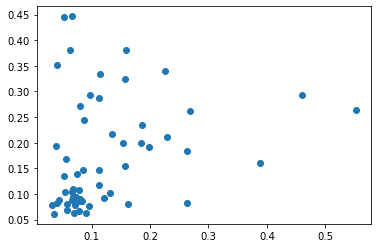

In [22]:
plt.scatter(x, y)

In [23]:
x = []
y = []
for cmp, lwf, lwn, pkf, pkn in zip(exp_compounds_4k, all_lws_fit, sel2_all_lws_net, all_pks_fit, sel2_all_pks_net):
    print(cmp)
    for lf, ln, pf, pn in zip(lwf, lwn, pkf, pkn):
        print(f"  {pf:.2f}, {pn:.2f}, {lf:.2f}, {ln:.2f}")
        x.append(pf)
        y.append(pn)

x = np.array(x)
y = np.array(y)

ampicillin
  0.46, 0.38, 0.16, 0.38
  1.47, 1.39, 0.11, 0.33
  3.88, 3.83, 0.08, 0.27
  4.52, 4.59, 0.16, 0.15
  5.04, 5.08, 0.18, 0.20
  6.35, 6.36, 0.13, 0.22
  9.98, 9.78, 0.11, 0.29
aspala
  0.79, 0.80, 0.05, 0.14
  2.01, 2.08, 0.06, 0.07
  2.68, 2.63, 0.03, 0.06
  3.87, 3.88, 0.08, 0.07
  4.75, 4.77, 0.04, 0.09
  7.26, 7.27, 0.08, 0.09
  7.87, 7.91, 0.04, 0.19
  12.54, 12.58, 0.12, 0.09
flutamide
  1.06, 0.97, 0.16, 0.32
  1.91, 2.01, 0.11, 0.15
  7.16, 7.01, 0.55, 0.26
  7.84, 7.84, 0.19, 0.23
  9.91, 9.79, 0.39, 0.16
histidine
  2.72, 2.68, 0.10, 0.29
  3.33, 2.98, 0.06, 0.17
  5.01, 5.06, 0.10, 0.08
  7.36, 7.41, 0.07, 0.09
  8.80, 8.84, 0.09, 0.06
  12.27, 12.23, 0.26, 0.08
  16.88, 16.87, 0.16, 0.08
thymol
  0.41, 0.43, 0.05, 0.45
  1.08, 1.10, 0.06, 0.38
  1.48, 1.56, 0.07, 0.45
  3.31, 3.39, 0.15, 0.20
  5.23, 5.41, 0.27, 0.26
  6.12, 6.20, 0.23, 0.21
  6.91, 7.02, 0.26, 0.18
  9.29, 9.34, 0.08, 0.11
tyrosine
  2.47, 2.45, 0.08, 0.09
  6.49, 6.54, 0.03, 0.08
  7.23, 7.27, 0

In [24]:
np.sqrt(np.mean(np.square(x-y)))

0.09297623551360899

In [25]:
np.corrcoef(x, y)[0, 1] ** 2

0.9993339022774848